#Yelp online business reviews
Can we learn form the Yelp datasets to understans why business are closed?

Yele is an online user-genrated plaform for busienss reviews. "Yelp is a local-search service powered by crowd-sourced review forum run by an American multinational corporation headquartered in San Francisco, California, " noted on Wikipeida.org. 

Yelp open dataset is an all-purpose dataset for laerning. It is a subset of  Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the dataset you'll find information about businesses across 11 metropolitan areas in four countries.

The dataset use is focusing on 'businesss' to begin with. Later the 'chceckins'  are added to enhcance feaeatures of model. 'Review' dataset is combined during exploratory data analytics.

In [3]:
import json 
import pandas as pd 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from string import ascii_letters
from wordcloud import WordCloud,STOPWORDS
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc,roc_auc_score,classification_report,f1_score

sns.set_style('white')

In [4]:
path="/dbfs/mnt/reviewdata/yelpdata/yelp_review.csv"
review =pd.read_csv(path)
raw_business = pd.read_csv("/dbfs/FileStore/tables/yelp_business.csv")

In [5]:
#Leave only business name and id  
business_name = raw_business.drop(['stars','review_count','categories','is_open','neighborhood', 'address', 'city', 'state','postal_code', 'latitude', 'longitude'], axis = 1)
business_name.head()
# Merge the reivew data set with the previous data framed created so there is business name 
review = pd.merge(review, business_name, on = 'business_id')
review.head()

Out[ 5 ]: 
 review_id user_id business_id \
0 vkVSCC7xljjrAI4UGfnKEQ bv2nCi5Qv5vroFiqKGopiw AEx2SYEUJmTxVVB18LlCwA 
1 vm1b1keOzwHjtGZEPPuYXA xYciRtVZ1PW4IxSX4oJ1aw AEx2SYEUJmTxVVB18LlCwA 
2 SXwA9KZ-Nc_hMARk_3cJ7g 5Ymfsf9fAYz-Ds_p0xawVQ AEx2SYEUJmTxVVB18LlCwA 
3 jUzausdZ_ujqe_n8BlBj-g DVOOF0Z627DyrZ4XKQbTgA AEx2SYEUJmTxVVB18LlCwA 
4 oCRDwF3tszAkeszSfxwthg 5JoKz3mU42Cp906KRXDwJw AEx2SYEUJmTxVVB18LlCwA 

 stars date text \
0 5 2016-05-28 Super simple place but amazing nonetheless. It... 
1 5 2016-02-22 *The shop was featured on Mind of a Chef with ... 
2 5 2013-03-29 As its name suggests, Wilensky's is a lunch co... 
3 5 2017-08-08 Stopped by for the Wilensky's Special, loved i... 
4 4 2009-01-17 I have to admit, I am a fan. Just entering the... 

 useful funny cool name 
0 0 0 0 "Wilensky's" 
1 4 3 4 "Wilensky's" 
2 9 0 3 "Wilensky's" 
3 0 0 0 "Wilensky's" 
4 4 0 1 "Wilensky's"

#1)Exploratory Data Analysis

In [7]:
raw_business.describe()
#average rating for business is 3.63. Total rnumber of business is 174567.

Out[ 18 ]: 
 latitude longitude stars review_count \
count 174566.000000 174566.000000 174567.000000 174567.000000 
mean 38.627312 -92.679009 3.632196 30.137059 
std 5.389012 26.240079 1.003739 98.208174 
min -36.086009 -142.466650 1.000000 3.000000 
25% 33.631550 -112.125879 3.000000 4.000000 
50% 36.144257 -89.410128 3.500000 8.000000 
75% 43.606181 -79.657609 4.500000 23.000000 
max 89.999314 115.086769 5.000000 7361.000000 

 is_open 
count 174567.000000 
mean 0.840376 
std 0.366258 
min 0.000000 
25% 1.000000 
50% 1.000000 
75% 1.000000 
max 1.000000

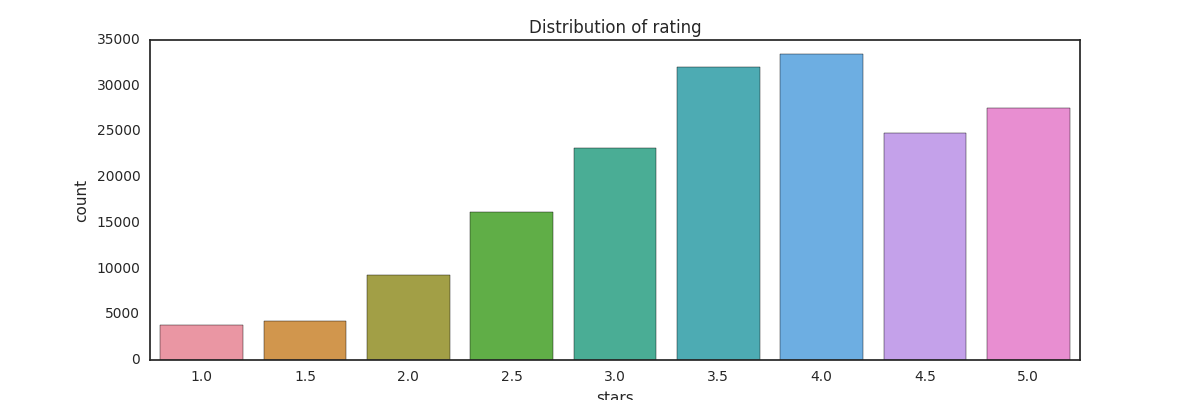

In [8]:
plt.figure(figsize=(12,4))
ax = sns.countplot(raw_business['stars'])
plt.title('Distribution of rating')
display()
#The distributiotn of the business rating looks similar to normal distribution with the mean around 3.5-4.0 ratings.

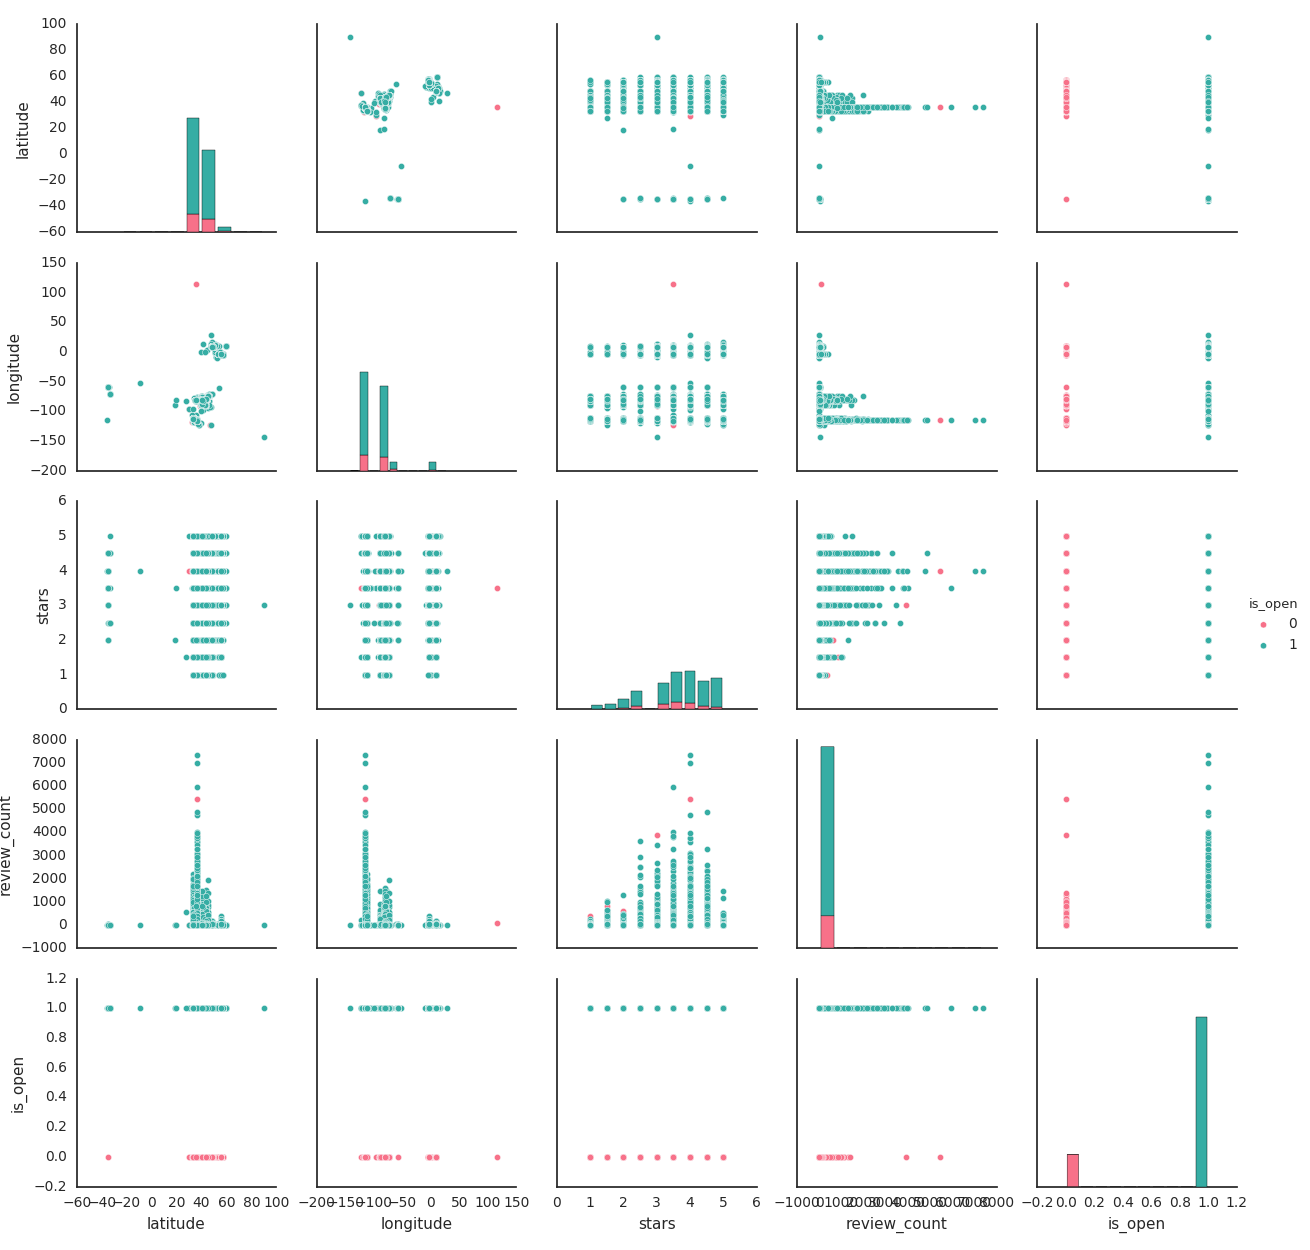

In [9]:
sns.pairplot(raw_business, hue="is_open",palette="husl")
display()

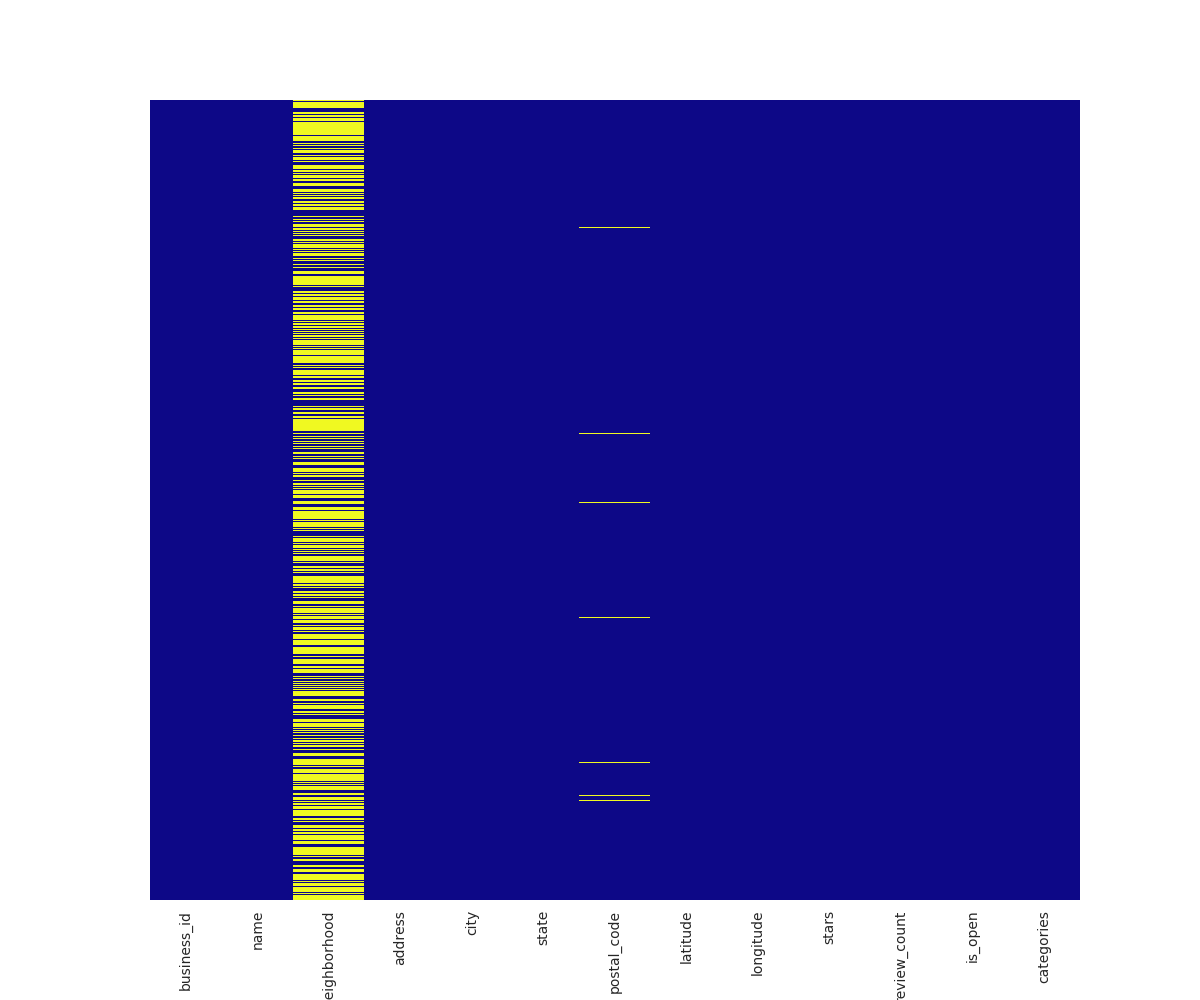

In [10]:
plt.figure(figsize=(12,10))
f = sns.heatmap(raw_business.isnull(),yticklabels=False, cbar=False, cmap = 'plasma')
display()
#Columns with most missing data is the neighborhood and the second is the postal code. Other columns might have missing data as well yet they did not show on the heat map. 

In [11]:
# To find missing data by columns:
raw_business.isnull().sum()

Out[ 19 ]: 
business_id 0
name 0
neighborhood 106552
address 0
city 1
state 1
postal_code 623
latitude 1
longitude 1
stars 0
review_count 0
is_open 0
categories 0
dtype: int64

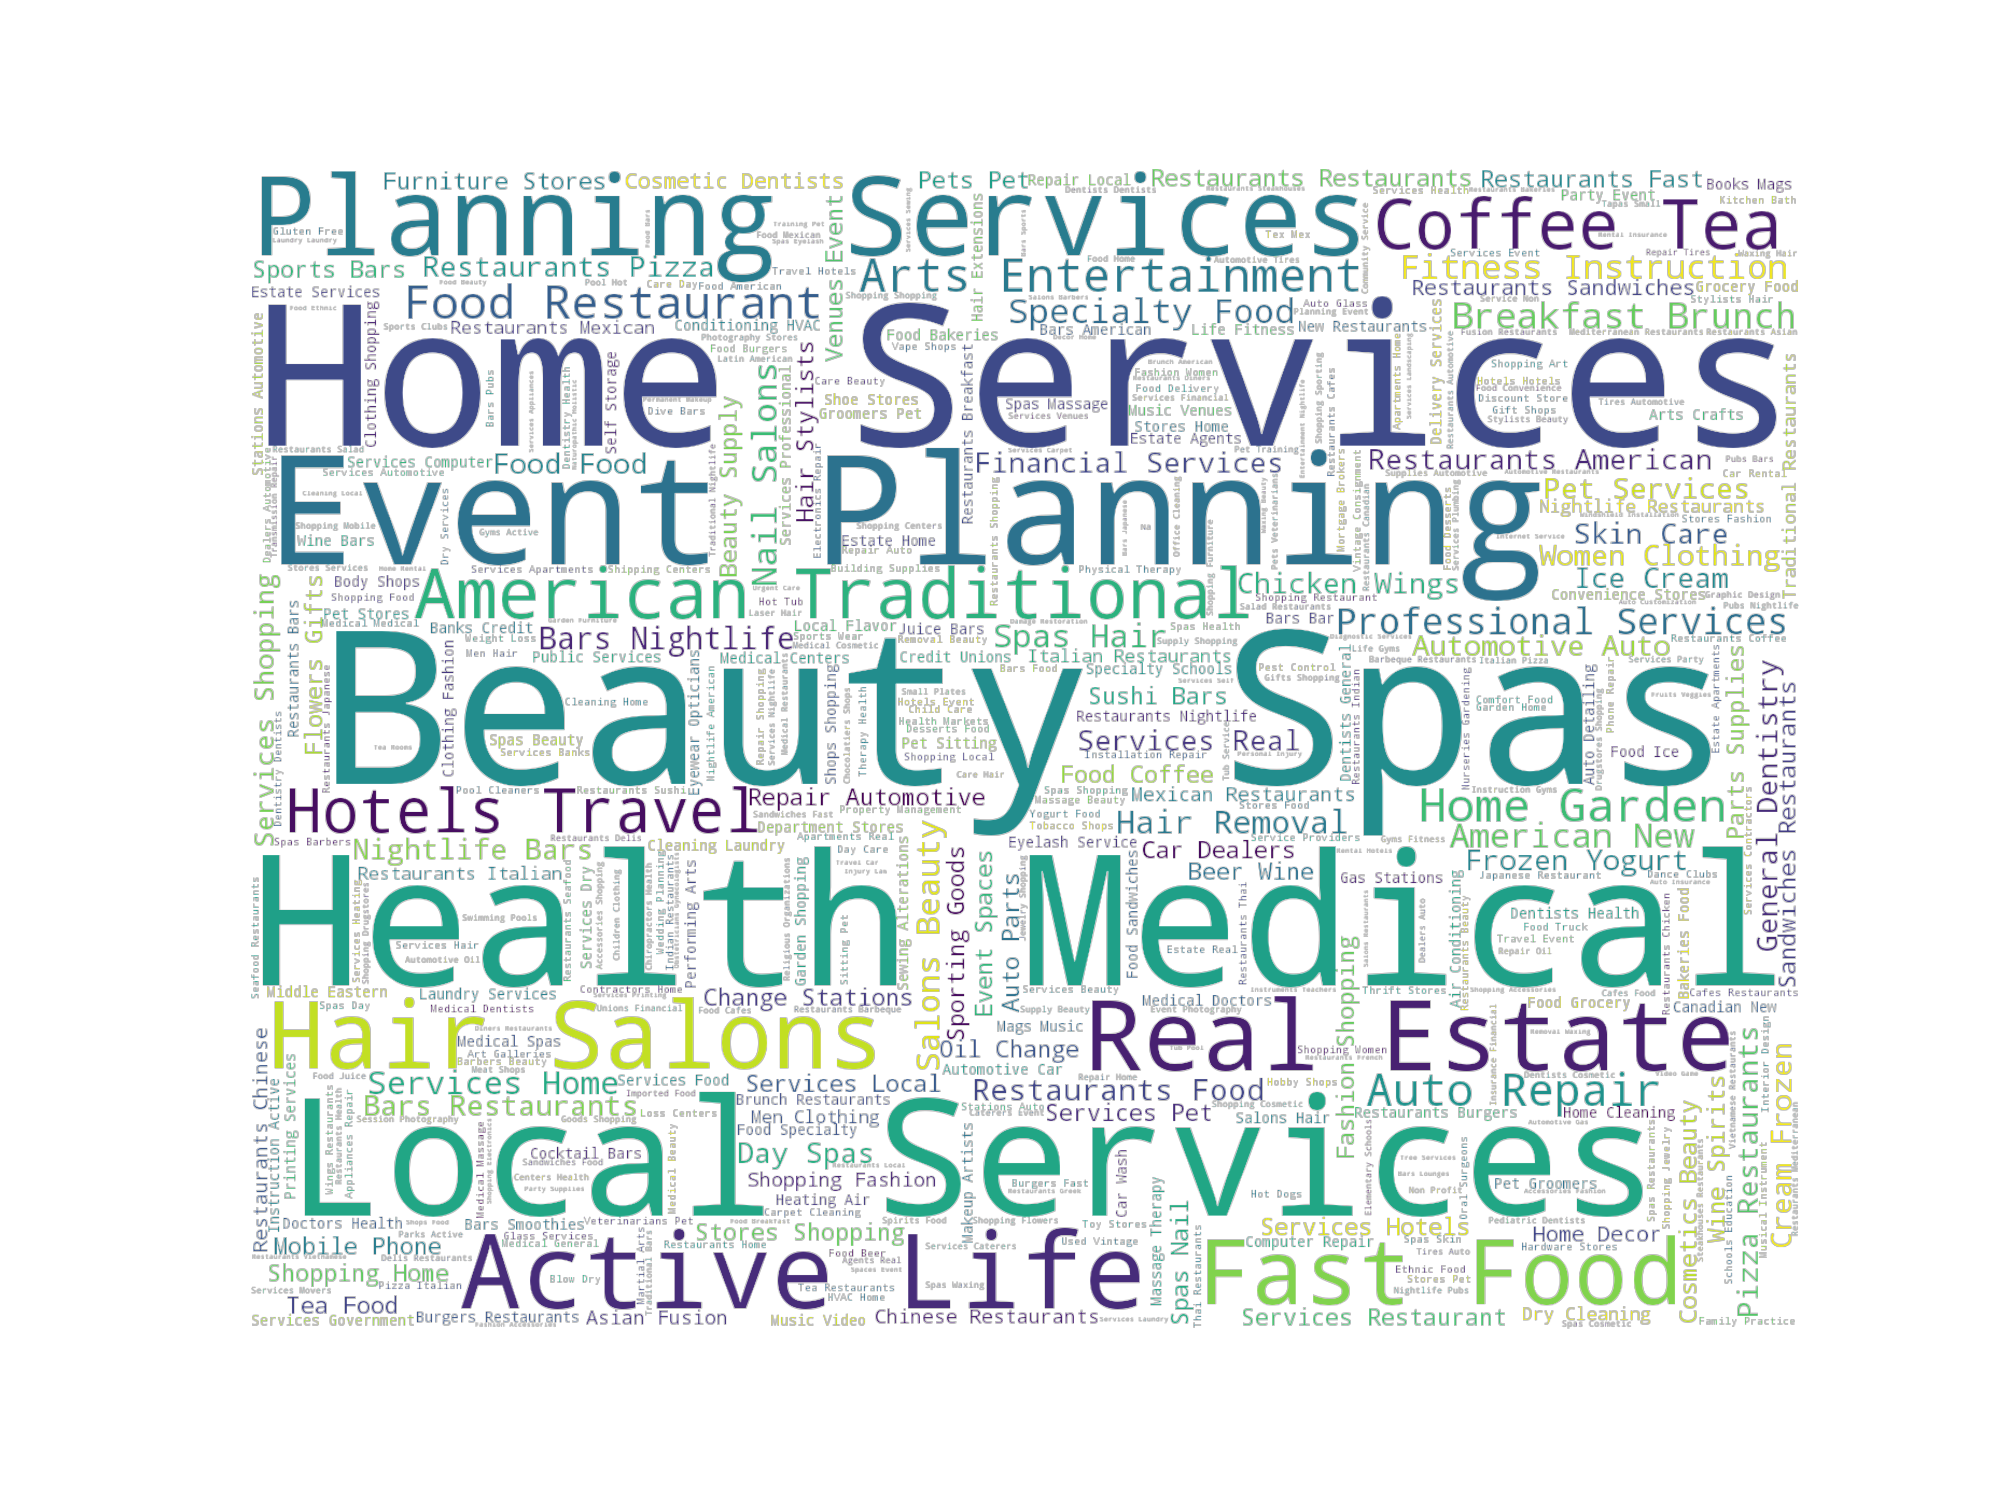

In [12]:
cloud = WordCloud(width=1440, height= 1080,stopwords = STOPWORDS, max_words= 500,background_color="rgba(255, 255, 255, 0)", mode="RGBA").generate(' '.join(raw_business['categories'].astype(str)))
plt.figure(figsize=(20, 15))
fig = plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.show(fig)
display()
#https://www.datacamp.com/community/tutorials/wordcloud-python#find datasets paths

In [13]:
city_business_reviews = raw_business[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

Out[ 7 ]: 
 review_count stars
city 
Las Vegas 1604173 3.709916
Phoenix 576709 3.673793
Toronto 430923 3.487272
Scottsdale 308529 3.948529
Charlotte 237115 3.571554
Pittsburgh 179471 3.629819
Henderson 166884 3.789362
Tempe 162772 3.729885
Mesa 130883 3.636024
Montréal 122620 3.706604

In [14]:
review.groupby('name')['stars'].mean().sort_values(ascending=False).head()


Out[ 8 ]: 
name
""T"s Hair Affair" 5.0
"Pool Tile Dr" 5.0
"Hair By Alis" 5.0
"Hair By Albina" 5.0
"Hair By Adrienne - Making Waves Hair Studio" 5.0
Name: stars, dtype: float64

In [15]:
review.groupby('name')['stars'].count().sort_values(ascending=False).head()

Out[ 9 ]: 
name
"Starbucks" 19518
"Hash House A Go Go" 9840
"McDonald's" 9415
"Chipotle Mexican Grill" 7980
"Mon Ami Gabi" 7362
Name: stars, dtype: int64

In [16]:
ratings = pd.DataFrame(review.groupby('name')['stars'].mean())
ratings['num of ratings'] = pd.DataFrame(review.groupby('name')['stars'].count())
ratings =ratings.sort_values(by = 'num of ratings', ascending = False)
ratings.head()

Out[ 10 ]: 
 stars num of ratings
name 
"Hash House A Go Go" 3.778963 9840
"McDonald's" 2.072119 9415
"Chipotle Mexican Grill" 3.030952 7980
"Mon Ami Gabi" 4.120484 7362
"Bacchanal Buffet" 3.770340 7006

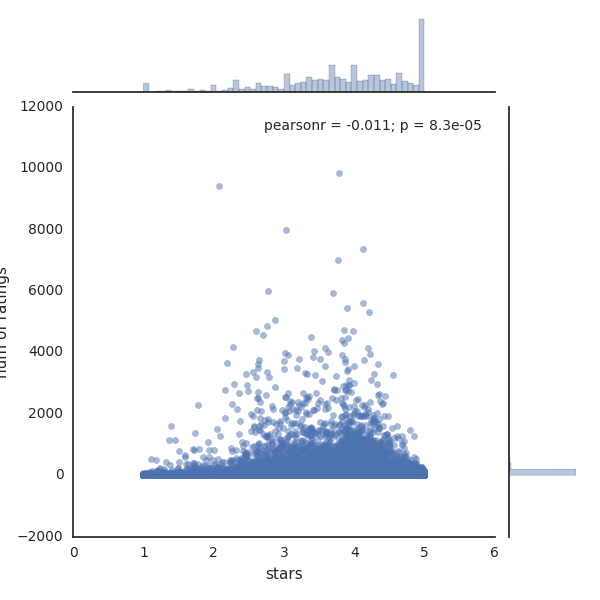

In [17]:
sns.jointplot(x='stars',y='num of ratings',data=ratings,alpha=0.5)
display()

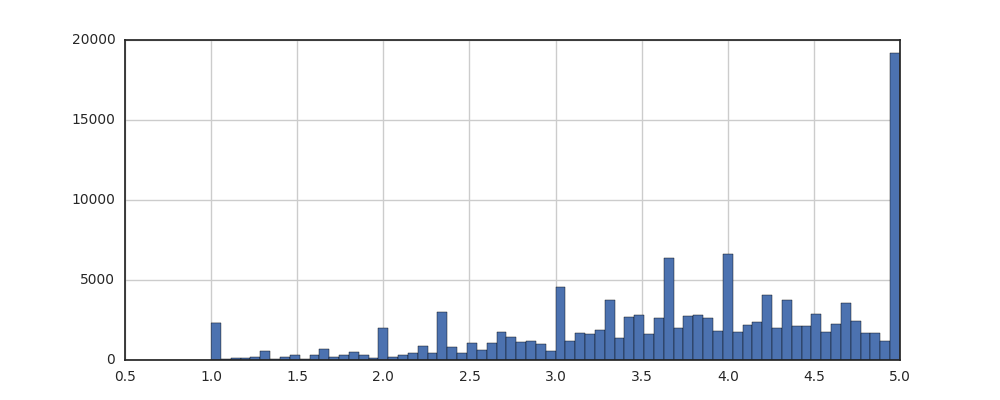

In [18]:
plt.figure(figsize=(10,4))
ratings['stars'].hist(bins=70)
display()

Notice the numbers of five star reviews seem to be abnormaly high comapring to the previous distribution graph. In this graph the 'stars' was aggregated by business name and the business with the most numbers of reviews is 'Starbucks'with each franchisee share the same business ID. Since the numbers of rating is three times of the next one, Starbucs can be consider as a outlier and is removed from the dataset.

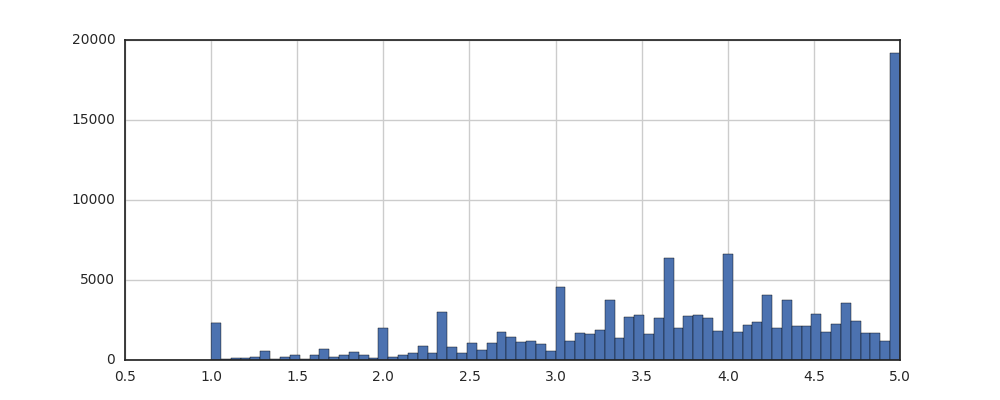

In [20]:
review = review[review['name']!='"Starbucks"']
ratings2 = pd.DataFrame(review.groupby('name')['stars'].mean())
ratings2['num of ratings'] = pd.DataFrame(review.groupby('name')['stars'].count())
ratings2 =ratings2.sort_values(by = 'num of ratings', ascending = False)

plt.figure(figsize=(10,4))
ratings['stars'].hist(bins=70)
display()
#The histogram does not seem changed after remove outlier. 

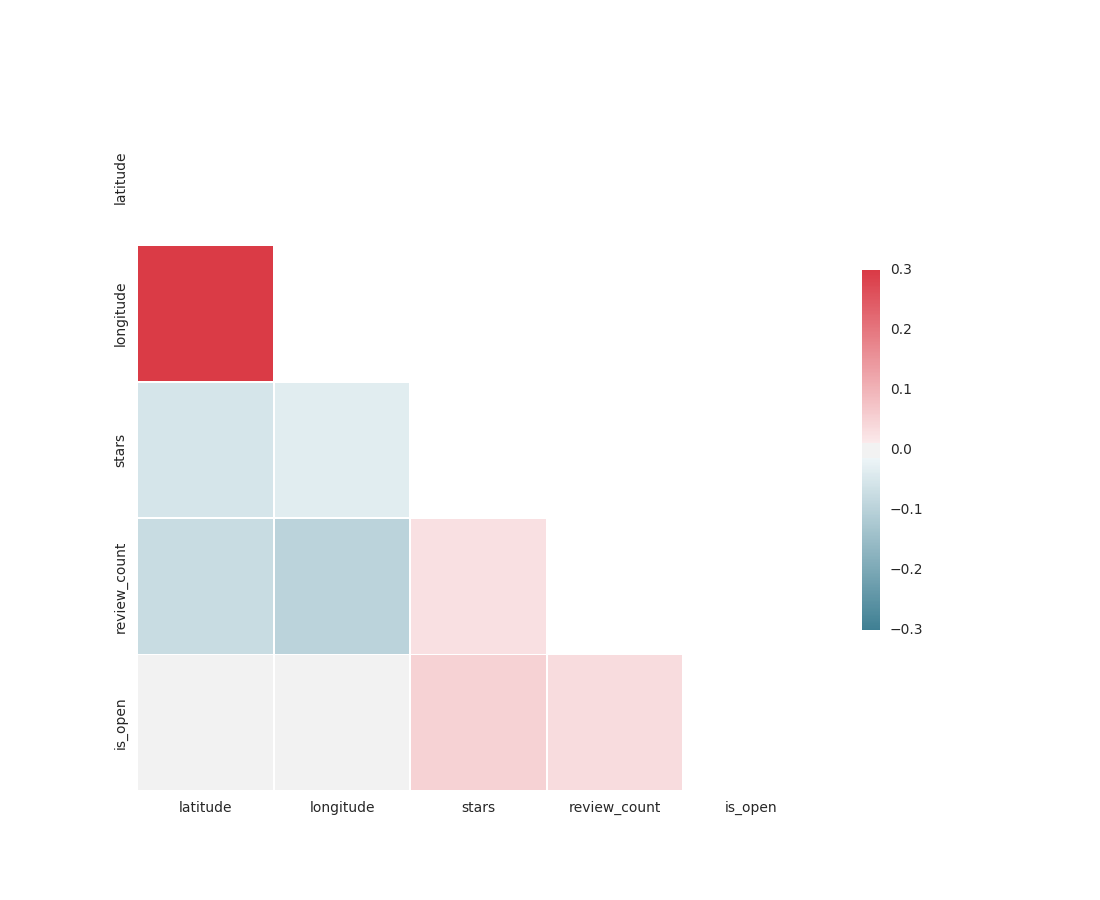

In [21]:
# Compute the correlation matrix
corr = raw_business.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
display()

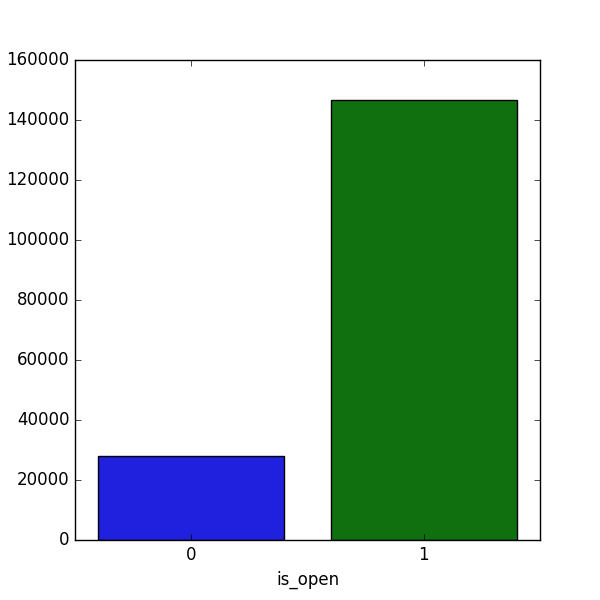

In [22]:
plt.figure(figsize=(6,6))
sns.countplot(x='is_open',data=business)
display()

## Is the Business Open or Closed?
Starting with logistic regression,  the goal is to predict binary result of either a business is open or close based on the chosen features. The label is set to be 'is_open' column where '1' means businss is still operating at the time of data generated while '0' means the opposite. Four features used at first, including latitude, longitude, stars and numbers of ratings.  

To simplify the process, features chosen are all numeric. Data set is split into training and testing sets. Evaluation of models are based on their ROC_AUC after five folds of cross validatoins. In the mean time f1-score are use as reference and accuracy scores are avoid until data is resampled.

In [24]:
# Selecting feature
feature_cols = ['latitude','longitude','stars','review_count']
X= raw_business[feature_cols]
y= raw_business['is_open']

In [25]:
X.fillna(0.0,inplace=True)
#replacing NaN with zero which should not affect the model too much based on the heatmap in EDA.

/databricks/python/local/lib/python2.7/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 downcast=downcast, **kwargs)

In [26]:
# Spliting data and scalling data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
scaler_features= scaler.transform(X_train)
X_train = pd.DataFrame(scaler_features, columns =['latitude','longitude','stars','review_count']) 
X_test = scaler.transform(X_test)
X_train.head()

Out[ 26 ]: 
 latitude longitude stars review_count
0 -0.958142 -0.745105 0.366719 0.083470
1 0.934648 0.507506 -0.131175 -0.253539
2 -0.464007 -0.857018 1.362509 -0.190350
3 -0.631823 0.453997 1.362509 -0.232476
4 0.940223 0.505655 -0.131175 0.094002

In [27]:
# Model development and prediction
log = LogisticRegression()
log.fit(X_train,y_train) #fit the model with training set
print (log.coef_)
print (log.intercept_)
y_pred=log.predict(X_test)

[[-0.13455652 0.16165427 0.13304537 0.19798593]]
[ 1.68056658]

In [28]:
confusion_matrix(y_test,y_pred)
conf =np.matrix(confusion_matrix(y_test,y_pred))
print(conf)
print('Accuracy:',accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[ 0 5598]
 [ 0 29316]]
('Accuracy:', 0.83966317236638599)
/databricks/python/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
 'precision', 'predicted', average, warn_for)
 precision recall f1-score support

 0 0.00 0.00 0.00 5598
 1 0.84 1.00 0.91 29316

avg / total 0.71 0.84 0.77 34914

In [29]:
#with cross-validation to see if the error rate is closed to the previous one
scores = cross_val_score(log, X, y, cv = 5)
print('Aveagrage CV accuracy/error/score', scores.mean())
print('Standard deveation of CV accuracy is:',scores.std())
print(classification_report(y_test, y_pred))

('Aveagrage CV accuracy/error/score', 0.84037647433085083)
('Standard deveation of CV accuracy is:', 2.2397930252631339e-06)
 precision recall f1-score support

 0 0.00 0.00 0.00 5634
 1 0.84 1.00 0.91 29280

avg / total 0.70 0.84 0.77 34914

In [30]:
#incrase cv to 7 
scores = cross_val_score(log, X, y, cv = 7)
print('Aveagrage CV accuracy/error/score', scores.mean())
print('Standard deveation of CV accuracy is:',scores.std())
print(classification_report(y_test, y_pred))

('Aveagrage CV accuracy/error/score', 0.84037647470923793)
('Standard deveation of CV accuracy is:', 1.3746754049388459e-05)
 precision recall f1-score support

 0 0.00 0.00 0.00 5634
 1 0.84 1.00 0.91 29280

avg / total 0.70 0.84 0.77 34914

Incrasings CV fold seem to improve acuracy slightly but overall the model barely beats randon guesses. This model is under fit and more features is required to improve model prediction.

Considering other feature tha might contribute to a running business, or, the other way around, what might a operating business presents in the dataset. Another table in this dataset is users' check in information. May be the more check in the better a bussines is run?

The numbers of review and ratings do not seem to mean much as show in the model here since the ROC was not as good as expected.

This dataset has around 15% of business are closed and the accuracy of this odel is 83.86%. If the modle predicts all of the target to be open then the accuracy would have been very closed to 85% which is what we see here. 

Next, adding features such as check-ins, mean and avearge of ratings to see if we can better predict the target.

In [32]:
#Create features with existing ones by taking hte mean median of the ratings. 
review_busines = review.groupby(by='business_id')

review_businesid = pd.DataFrame()
review_businesid['Mean'] = review_busines['stars'].mean()
review_businesid['Median'] = review_busines['stars'].median()
review_businesid['NumberOfReviews'] = review_busines['stars'].count()
review_businesid.head()

Out[ 28 ]: 
 Mean Median NumberOfReviews
business_id 
--6MefnULPED_I942VcFNA 3.135135 3.0 37
--7zmmkVg-IMGaXbuVd0SQ 3.851064 4.0 47
--8LPVSo5i0Oo61X01sV9A 4.333333 5.0 3
--9QQLMTbFzLJ_oT-ON3Xw 3.363636 4.0 11
--9e1ONYQuAa-CB_Rrw7Tw 4.088904 4.0 1451

In [33]:
#Conbine check-in table to dataframed 
checkin = pd.read_csv("/dbfs/FileStore/tables/yelp_checkin.csv")
checkin_bus = checkin.groupby(by = 'business_id')

checkin_busid = pd.DataFrame()
checkin_busid['TotalCheckins'] = checkin_bus['checkins'].sum()

checkin_busid.reset_index(inplace=True)
review_businesid.reset_index(inplace=True)

review_businesid = pd.merge(left=review_businesid,right=checkin_busid,on='business_id', how='left')

business = pd.merge(raw_business,review_businesid ,on='business_id')
business.head()


Out[ 29 ]: 
 business_id name neighborhood \
0 FYWN1wneV18bWNgQjJ2GNg "Dental by Design" NaN 
1 He-G7vWjzVUysIKrfNbPUQ "Stephen Szabo Salon" NaN 
2 KQPW8lFf1y5BT2MxiSZ3QA "Western Motor Vehicle" NaN 
3 8DShNS-LuFqpEWIp0HxijA "Sports Authority" NaN 
4 PfOCPjBrlQAnz__NXj9h_w "Brick House Tavern + Tap" NaN 

 address city state postal_code \
0 "4855 E Warner Rd, Ste B9" Ahwatukee AZ 85044 
1 "3101 Washington Rd" McMurray PA 15317 
2 "6025 N 27th Ave, Ste 1" Phoenix AZ 85017 
3 "5000 Arizona Mills Cr, Ste 435" Tempe AZ 85282 
4 "581 Howe Ave" Cuyahoga Falls OH 44221 

 latitude longitude stars review_count is_open \
0 33.330690 -111.978599 4.0 22 1 
1 40.291685 -80.104900 3.0 11 1 
2 33.524903 -112.115310 1.5 18 1 
3 33.383147 -111.964725 3.0 9 0 
4 41.119535 -81.475690 3.5 116 1 

 categories Mean Median \
0 Dentists;General Dentistry;Health & Medical;Or... 3.956522 5.0 
1 Hair Stylists;Hair Salons;Men's Hair Salons;Bl... 2.909091 2.0 
2 Departments of Motor Vehicles;Public Services ... 1.666667 1.0 
3 Sporting Goods;Shopping 2.777778 2.0 
4 American (New);Nightlife;Bars;Sandwiches;Ameri... 3.482759 4.0 

 NumberOfReviews TotalCheckins 
0 23 1.0 
1 11 1.0 
2 18 1.0 
3 9 1.0 
4 116 1.0

In [34]:
#select features. 
feature_cols= ['stars','Mean','Median','NumberOfReviews','TotalCheckins','latitude', 'longitude']
X = business[feature_cols]
y = business['is_open']
X.fillna(0.0,inplace=True) 

# Spliting and scalling data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Train set 'close' pct = {:.2f}%".format(100 * (y_train == 0).mean()))
print("Test  set ''close'' pct = {:.2f}%".format(100 * (y_test == 0).mean()))
print('\n')

scaler = StandardScaler()
scaler.fit(X_train)
scaler_features = scaler.transform(X_train)
X_train = pd.DataFrame(scaler_features, columns = feature_cols) 
X_test = pd.DataFrame(scaler.transform(X_test),columns = feature_cols)

# Model development and prediction
log2 = LogisticRegression()
log2.fit(X_train,y_train) #fit the model with training set
y_pred=log2.predict(X_test)
print (log2.coef_)
print (log2.intercept_)
print('\n')
conf = confusion_matrix(y_test,y_pred)
print(conf)
print('Accuracy:', accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Train set 'close' pct = 16.02%
Test set ''close'' pct = 15.98%


[[-0.04575215 0.25936684 -0.08399923 0.24233372 -0.06345594 -0.12279136
 0.14671017]]
[ 1.67570445]


[[ 0 5550]
 [ 0 29177]]
('Accuracy:', 0.84018199095804413)
/databricks/python/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
 'precision', 'predicted', average, warn_for)
 precision recall f1-score support

 0 0.00 0.00 0.00 5550
 1 0.84 1.00 0.91 29177

avg / total 0.71 0.84 0.77 34727

Around 15% of the business in this dataset is closed. Majority of the 'is_open' column has value of 1. This imbalance of training lable might cause the predcition of model liening toward '1' and the performance improvment could be limited unless dataset was restructured. 
Based on the coefficient of the features, numbers of reviews has most impact on othe target. Second next to it will be the average of the ratings.

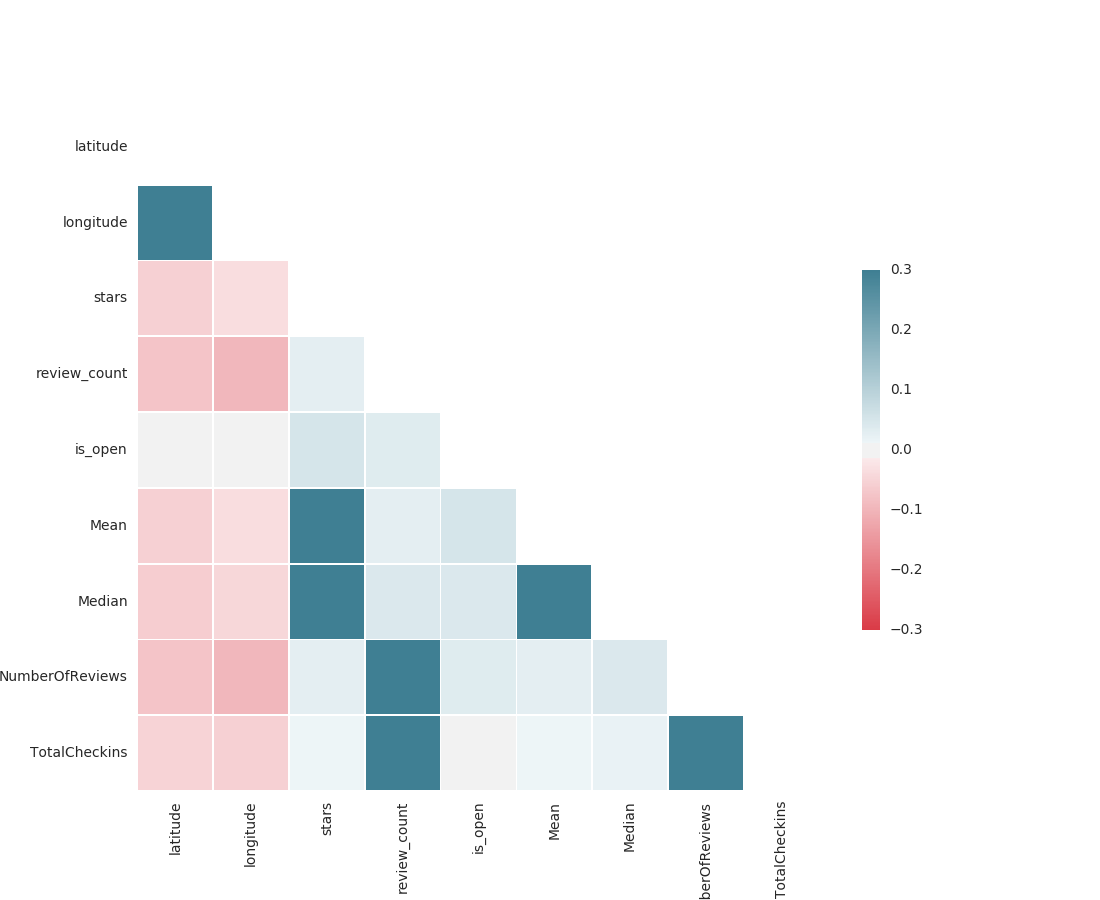

In [36]:
sns.set(style="white")

# Compute the correlation matrix
corr = business.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
display()

In [37]:
# create the RFE model and select 3 attributes
rfe = RFE(log2, 3)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes which share smilar results as logistic regerssion.
print(feature_cols)
print(rfe.support_)
print(rfe.ranking_)

['stars', 'Mean', 'Median', 'NumberOfReviews', 'TotalCheckins', 'latitude', 'longitude']
[False True False True False False True]
[5 1 3 1 4 2 1]

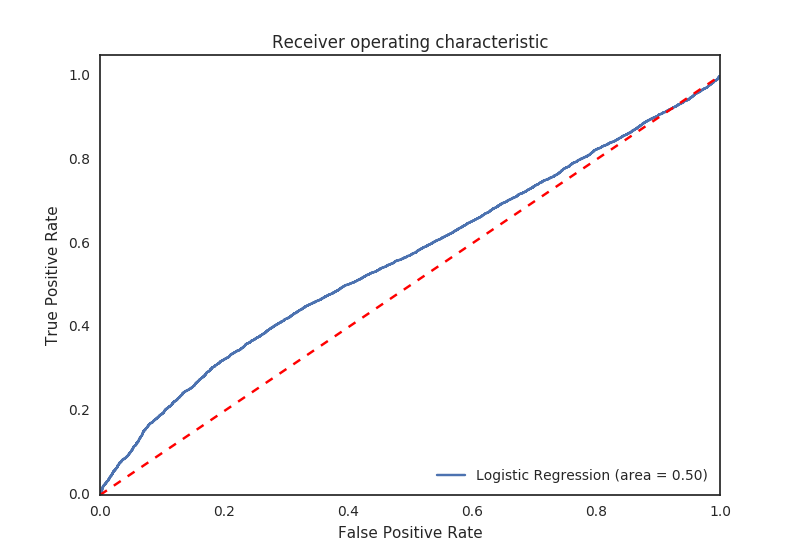

In [38]:
logit_roc_auc = roc_auc_score(y_test, log2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
display()

This model seem to be high on accuracy but ROC shows the model is not much better than random guess. This coinside with the earlier confusion matrix where model predict all the target to be open. 
Time to try other algorithm.

##Building More Models

Other than Logistic Regression, algorithms that is suitable for models are Decision Tree, Random Forest, K-Nearest Neighbor, and XGBoost. Four of these algorithms are add to model supervised classification.

In [41]:
scoring = 'f1_weighted'

#Spot check algorithms
models = []
models.append(('1. LR', LogisticRegression()))
models.append(('2. CART', DecisionTreeClassifier()))
models.append(('3. RF', RandomForestClassifier(n_estimators=100)))
models.append(('4. KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('5. xgb', XGBClassifier()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 5, random_state = 123)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


/databricks/python/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
 'precision', 'predicted', average, warn_for)
1. LR: 0.766599 (0.003085)
2. CART: 0.748743 (0.001398)
3. RF: 0.780758 (0.003026)
4. KNN: 0.777295 (0.002049)
5. xgb: 0.766609 (0.003079)

In [42]:
scoring = 'roc_auc'

#Spot check algorithms
models = []
models.append(('1. LR', LogisticRegression()))
models.append(('2. CART', DecisionTreeClassifier()))
models.append(('3. RF', RandomForestClassifier(n_estimators=100)))
models.append(('4. KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('5. xgb', XGBClassifier()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 5, random_state = 123)
    cv_results = model_selection.cross_val_score(model, X_train, y_train,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1. LR: 0.564291 (0.003536)
2. CART: 0.542650 (0.002754)
3. RF: 0.636174 (0.002455)
4. KNN: 0.595716 (0.004787)
5. xgb: 0.675820 (0.001955)

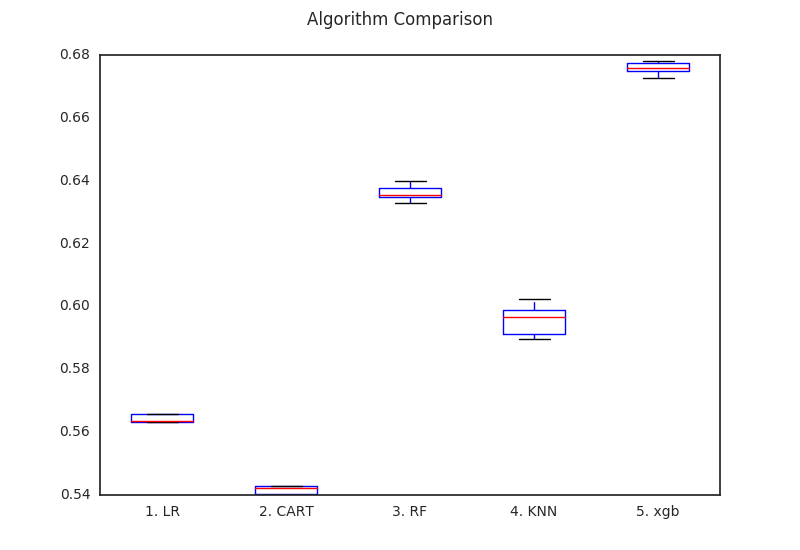

In [43]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
display()

All models shared around 0.77 weighted f1-socre while ROC_AUC shows the XGBooster out performed all other models with the score of 0.675820. Let's see how it will perform in the test set.

In [45]:
# Select best model
# Make predictions on validation dataset

xgb = XGBClassifier()
fit = xgb.fit(X_train, y_train)
xgb.pred = xgb.predict(X_test)
print('Overall roc_auc score:', roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

('Overall roc_auc score:', 0.67824442429199605)

Test set on the XGBooster has ROC_AUC around 0.6782 which is better than Logistic Regression model earlier but still not quite enough.

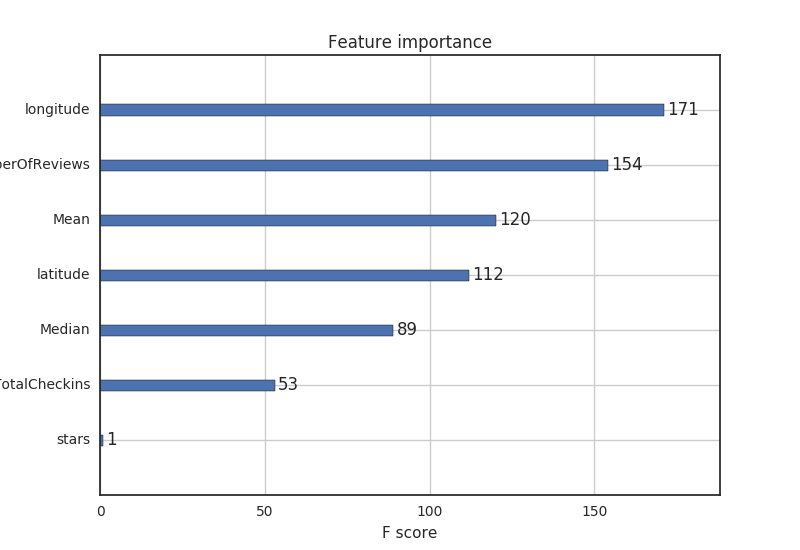

In [47]:
from xgboost import XGBClassifier
from xgboost import plot_importance
plot_importance(xgb)
pyplot.show()
display()

This feature importance plot shows somehow differnet result as the previous model Log2. XGBooster consider longtitude to be the most important feature while Logestitc regression model was mostly impacted by the number of reviews.

##Reshaping data by over-samplinging using SMOTE
As seen on the bar plot ealier, the numbers of business closed is dispropotional to those that is open. If under-sampling method were applied, the training set data would have been too small. Therefore, over-sampling method such as SMOTE would be more approriate. SMOTE simulate sampling points near decision boundry and generate samples in the opposite direction of the nearest neigbors class.

In [50]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.svm import LinearSVC
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))


[(0, 116645), (1, 116645)]

In [51]:
X_resampled = pd.DataFrame(X_resampled,columns = X_train.columns.tolist())

In [52]:
scoring = 'f1_weighted'

#Spot check algorithms
models = []
models.append(('1. LR', LogisticRegression()))
models.append(('2. CART', DecisionTreeClassifier()))
models.append(('3. RF', RandomForestClassifier(n_estimators=100)))
models.append(('4. KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('5. xgb', XGBClassifier()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits = 5, random_state = 123)
    cv_results = model_selection.cross_val_score(model, X_resampled, y_resampled,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/databricks/python/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
 'recall', 'true', average, warn_for)
1. LR: 0.088070 (0.069283)
2. CART: 0.776568 (0.059168)
3. RF: 0.825350 (0.062766)
4. KNN: 0.721130 (0.092086)
5. xgb: 0.580912 (0.012376)

In [53]:
scoring = 'roc_auc'
from sklearn.model_selection import StratifiedKFold
#Spot check algorithms
models = []
models.append(('1. LR', LogisticRegression()))
models.append(('2. CART', DecisionTreeClassifier()))
models.append(('3. RF', RandomForestClassifier(n_estimators=100)))
models.append(('4. KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('5. xgb', XGBClassifier()))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.StratifiedKFold(n_splits = 5, random_state = 123)
    cv_results = model_selection.cross_val_score(model, X_resampled, y_resampled,
                                                cv = kfold, 
                                                 scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1. LR: 0.566635 (0.001894)
2. CART: 0.749767 (0.046675)
3. RF: 0.909432 (0.035501)
4. KNN: 0.810999 (0.009141)
5. xgb: 0.755969 (0.046199)

In [54]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_estimators=100)

# Train the Classifier to take the training features and learn how they relate
# to the training y
clf.fit(X_train, y_train)
# Apply the Classifier to the test data
y_pred=clf.predict(X_test)
# Probabilities for each class
y_probs = clf.predict_proba(X_test)[:, 1]
# Calculate roc auc
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

Out[ 99 ]: 0.63865684651646193

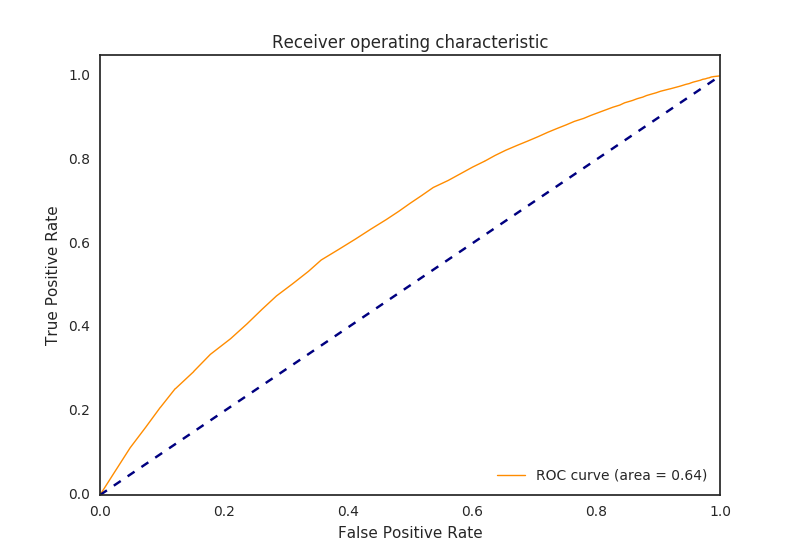

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
display()

In [56]:
#Find which features are important
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)
print feature_importances

importance
longitude 0.328001
latitude 0.324299
Mean 0.129830
NumberOfReviews 0.120966
TotalCheckins 0.042257
Median 0.037090
stars 0.017557

## To Sum Up

The result of using Random Forest to predict label after resampling the dataset does not seem to be better than XGBooster. It has ROC_AUC score of 0.6386 while the later is 0.67824. Yet, either one is better than Logistic Regression this project started with. The possible reason for Random Forest has high training score but low testing score might have to do with how resampling was done. Further modification on resampling is needed. 

In terms of factors effect label, XGBooster and Logistic Regression both agree on the top three being "average rating", "numer of reviews", and "longitude" while Random forest has top 3 being "longitude","latitude", and "average rating." All of them discard the importance of total numbers of checkins and the rating of the business. Beause of the performace of models, it is hard relate the effects of features on the label.

https://github.com/tarunparmar/Udacity-ML-Capstone/blob/master/CapstoneProject.ipynb

https://towardsdatascience.com/supervised-machine-learning-classification-5e685fe18a6d

https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

https://imbalanced-learn.org/en/stable/over_sampling.html

https://scikit-learn.org

https://seaborn.pydata.org

https://www.datacamp.com